# Accessions List
To run the pipeline more efficiently, I wanted to break up the 216 accessions into sets of 18, with each taking less than a day to run.

In [4]:
import pandas as pd

In [5]:
# read in the list of all the accessions with phenotypes
# df = pd.read_csv("/Users/eleanor/Documents/Spring2024/Frontiers/voichek_pipeline/accessions.csv")

In [10]:
# an empty list to store the accessions in, will be subset later
# into subsets of size 18
# ls = []

# for i in df['x']:
# #     string = "\"" + i + "\""
#     string = i
#     ls.append(string)

# # for the 216 accessions, step through them 18 at a time
# for j in range(0,216,18):
    
#     # a temporary list for holding the subsets
#     ls1 = []
    
#     # add the slice of accessions to the temporary list
#     ls1.append(ls[j:j+18])
    
#     # coerce them into a dataframe and write them out to a file
#     # with the number subset in the filename
#     df1 = pd.DataFrame(ls1)
#     filename = "run" + str(int(j/18)) + ".tsv"
#     df1.to_csv(filename, sep = ' ', header = False, index = False)

# Genotypes List
It became useful to narrow down the list of accessions with phenotypes to only those that also had genotypes. This `.csv` file contains the list of accessions with genotypes. The overlapping list was generated manually in Excel.

In [26]:
# # read in the file of accessions with genotypes
# df1 = pd.read_csv("/Users/eleanor/Documents/Spring2024/Frontiers/voichek_pipeline/genotype_accessions.csv", header = None)

# # an empty list for putting the accessions into
# ls1 = []

# # for each of the accessions in the .csv file
# for x in range(len(df1)):
    
#     # add each of the accessions to the empty list
#     # splitting the list elements into sub-list columns
#     ls1.append(df1.iloc[x,0].strip('\xa0').split())

# # now we have a nested list that can be coerced into a DataFrame
# df2 = pd.DataFrame(ls1)

# # we want a 1D list of accessions, which will be held in ls2
# ls2 = []

# # for each cell (x,y) in df2
# for y in range(len(ls1)):
#     for x in range(len(ls1[0])):
        
#         # append them to ls2
#         ls2.append(df2.iloc[x,y])

# # coerce this into a 1-column DataFrame and write it out to a file
# df3 = pd.DataFrame(ls2)
# df3.to_csv('genotypes.csv', sep = ',', header = None, index = None)

# Useful Stats Table
In the kmersGWAS manual, it recommends that we generate a 'useful statistics table' to generally QC the results. The table should contain:   
- the number of reads   
- the number of unique canonized k-mers  
- the number of non-canonized k-mers  
- the number of k- mers with each type of flag (1,2, or 3)   

These numbers can be used to generate plots to check things like number of reads vs. number of kmers, etc. 

In [1]:
# There is some provided code for generating this table from the kGWASflow pipeline
# so we'll start with those packages
import csv
import os, glob, shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from scipy import stats
import matplotlib.ticker as ticker

In [2]:
# we'll scrap all the stuff for the snakemake pipeline
# but keep the stuff that's universally applicable

# we need all the kmc_all.1 files from all the accessions
# to do this, we'll get the list of all the directories in the kmersGWAS folder
kmc_logs_path = "/mnt/scratch/carrele1/kmersGWAS_dir"

# dir_names= os.listdir(kmc_logs_path)
dir_names = ['BLV15', 'MCD09', 'RAP02', 'IFD02', 'AEM01', 
             'BER08', 'BER12', 'MED09', 'VER16', 'BRC09', 'MCD25',
             'VRN05', 'CHC14', 'CND09', 'KTZ10', 'CND04', 
             'CHC16', 'BRC04', 'BLV24', 'MED06', 'BER21', 'VER04', 'LGL03', 'VER13',
             'VRN01', 'BLV12', 'DDS15', 'VRN06', 'RAP06', 'BER11', 'MCD12', 'BER17', 
             'VER17', 'BLV05', 'BRC21', 'MCD17', 'VER10', 'CND14', 
             'OKA01', 'CND13', 'CND12', 'BER01', 'CND11', 'IFD17', 'BRC14', 'BRC13', 'BRC12', 
             'BRC11', 'KTZ06', 'VER14', 'MCD03', 'BRC06', 'CND06', 
             'CND01', 'DDS03', 'KTZ07', 'BER10', 'VER08', 'BRC01', 'BLV08', 'BER16', 'GND02', 
             'VER18', 'MED08', 'BLV18', 'KTZ08', 'RAP04', 'MCD18', 'BLV10', 'DDS05', 'KTZ09',
             'BLV19', 'MED05', 'BRC24', 'VER02', 'BER04', 'MED02', 'CHC11', 
             'OKA07', 'BER15', 'CHC13', 'VER19', 'BER02', 'MCD05', 'DDS12', 
             'RAP01', 'CHC01', 'AEM03', 'BLV16', 'DDS06', 'CHC09', 'GND05', 'BLV02', 'CHC08', 
             'BER14', 'OKA04', 'GND07', 'DDS08', 'MCD02', 'BER20', 'CHC07', 'VER05', 'VER06', 
             'KTZ02', 'CND07', 'BER05', 'CND02', 'RAP05', 'MED04', 'BRC02', 'KTZ03', 'DDS11', 
             'BLV13', 'BER03', 'KTZ04', 'BLV07', 'MED01', 'BLV09', 'BER19', 'DDS01', 'KTZ05', 
             'AEM06', 'BRC10', 'AEM04', 'BRC23', 'OKA06', 'EDN03', 'LGL02', 'MCD04', 'MCD21', 
             'MCD13', 'VER09', 'RAP03', 'BLV21', 'CHC10', 'CHC12', 'MCD11', 'BER18', 'EDN01', 
             'BER06', 'BLV11', 'IFD03', 'OKA03', 'MCD01', 'VER03', 'DDS02', 'MCD14', 'GND01', 
             'MED03', 'BLV01', 'EDN04', 'IFD04', 'LGL06', 'MCD19', 'CHC15', 'DDS04', 
             'RAP07', 'AEM05', 'GND03', 'BRC08', 'CND08', 'BRC19', 'CND03', 'BRC18', 'BLV22', 
             'BRC03', 'BRC17', 'CND19', 'CND17', 'IFD05', 'BRC16', 'CND16', 'CND15', 'BRC15', 
             'KTZ11', 'VRN02', 'BRC20', 'EDN02', 'VRN07',
             'BER09', 'OKA05', 'BLV04', 'BLV17', 'MCD24', 'BLV06', 'KTZ01', 'BER07', 'VER07', 'LGL05',
             'IFD14', 'BRC22', 'MCD07', 'CHC06', 'VRN03', 'IFD07', 'VER11', 'CHC05', 
             'GND04', 'CND36', 'CHC04', 'BLV23', 'BER13', 'DDS07', 'OKA02', 'GND06', 
             'VER01', 'BLV14', 'BRC05', 'CHC03',  'VRN04',  
             'IFD01', 'DDS09', 'CHC02']

In [3]:
## Define a function to generate k-mers count stats table 
# for each accession/sample. Accession name, no. total reads and no. of 
# unique k-mers as columns, samples are rows.
def generate_kmers_stats_tab(dir_path, file_name, dir_names):
    # Define lists to store values
    unique_kmers=[] # list to store unique k-mers
    total_reads=[] # list to store total reads
    accessions=[] # list to store accession names
        
    # For each accession/sample gather accesssion name,
    # from dir names and no. total reads and no. of unique 
    # k-mers from kmc log files.
    for dir in dir_names: # for each accession/sample
#         if os.path.isfile(dir_path + '/' + dir + '/' + file_name): # if kmc log file exists
        df = pd.read_csv(dir_path + '/' + dir + '/' + file_name, header = None) # read kmc log file
        df = df.drop(0, axis = 0)
        df = df.iloc[:,0].str.split(':', expand=True)        
#         print(df)
        unique_kmers.append(df.loc[df.iloc[:, 0] == "   No. of unique k-mers               ", 1].iloc[0].strip()) # append unique k-mers to list
        total_reads.append(df.loc[df.iloc[:, 0] == "   Total no. of reads                 ", 1].iloc[0].strip())  # append total reads to list
        accessions.append(dir) # append accession name to list

#     ## Create k-mers count stats table.
    target_df = pd.DataFrame(
            {'accessions': accessions,
             'unique_kmers': unique_kmers,
             'total_reads': total_reads
            })

#     ## Convert unique k-mers and total reads values to integer.
    target_df["unique_kmers"] = pd.to_numeric(target_df["unique_kmers"]) #
    target_df["total_reads"] = pd.to_numeric(target_df["total_reads"])
    return target_df # return k-mers count stats table

In [4]:
def plot_kmers_stats_scatter(target_df, out_file, plot_name):
        """
        Plot the scatter plot with regression line.
        """
        # Define x-axis and y-axis
        X=target_df["unique_kmers"] # Unique k-mers as x-axis
        Y=target_df["total_reads"] # Total reads as y-axis
        # Plot scatter plot
        plt.figure(figsize=(10, 10)) # set figure size
        plt.scatter(X, Y, alpha=0.5, s=200) 
        slope, intercept = np.polyfit(X, Y, 1) # calculate regression line
        plt.plot(X, slope*X + intercept,color="red") # plot regression line
        plt.xlabel("No. of unique kmers", fontsize=24) # add x-axis label
        plt.ylabel("No. of total reads", fontsize=24) # add y-axis label
        plt.xticks(fontsize = 18)
        plt.yticks(fontsize = 18)
        plt.title(plot_name) # add plot title
        plt.tight_layout() # tight layout
        plt.savefig(out_file, dpi=300) # save plot
        plt.close() # close plot

In [5]:
# Define a function to plot the joint plot with regression line and pearson correlation coefficient.
def plot_kmers_stats_joint(target_df, out_file, plot_name):
    # plot joint plot
    joint_plot= sns.jointplot(x="unique_kmers", y="total_reads", 
                                  data=target_df, # data
                                  kind="reg", # regression line
                                  height=10,
                                  joint_kws={'line_kws':{'color':'red'},
                                             'scatter_kws': {'s': 150}})
        
    # pearson correlation coefficient
    r, p = stats.pearsonr(target_df["unique_kmers"], target_df["total_reads"]) # calculate pearson correlation coefficient
    phantom, = joint_plot.ax_joint.plot([], [], linestyle="", alpha=0) # add pearson correlation coefficient to the legend
    legend = joint_plot.ax_joint.legend([phantom],['r={:f}, p={:f}'.format(r,p)]) # add pearson correlation coefficient to the legend
        
    # add x-axis label, y-axis label and plot title
    joint_plot.ax_joint.set_xlabel('No. of unique kmers', fontsize=24) # add x-axis label
    joint_plot.ax_joint.set_ylabel('No. of total reads', fontsize=24) # add y-axis label
    plt.figure(figsize=(10, 10)) # set figure size
    joint_plot.ax_joint.xaxis.set_tick_params(labelsize=18)
    joint_plot.ax_joint.yaxis.set_tick_params(labelsize=18)
    plt.setp(legend.get_texts(), fontsize='14') # for legend text
    joint_plot.fig.suptitle(plot_name, y = 1) # add plot title
    joint_plot.fig.tight_layout() # tight layout
    joint_plot.savefig(out_file, dpi=300) # save plot
    plt.close() # close plot

In [6]:
# Define a function to plot the distribution of k-mer counts for canonical and non-canonical k-mers.
def plot_kmer_dist(target_df, out_file, plot_name):
        # Plot the histogram of k-mer counts
        plt.figure(figsize=(10, 10)) # set figure size
        plt.hist(target_df["unique_kmers"], 
                 bins=30, 
                 color="#86bf91", 
                 alpha=0.5, 
                 edgecolor="black",
                 linewidth=1.2) #
        plt.xlabel("No. of unique kmers", fontsize=24) # add x-axis label
        plt.ylabel("No. of samples", fontsize=24) # add y-axis label
        plt.xticks(fontsize = 18)
        plt.yticks(fontsize = 18)
        plt.title(plot_name, fontsize=24) # add plot title
        plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0)) # set x-axis to scientific notation
        plt.gca().xaxis.set_major_formatter(plt.ScalarFormatter())
        
        # Add a boxed text indicating the total number of k-mers to the top right corner of the plot
        textstr = 'Total no. of k-mers:\n{:,}'.format(target_df["unique_kmers"].sum())
        # add box around the text
        plt.gca().text(0.95, 0.95, textstr, 
                       transform=plt.gca().transAxes, 
                       fontsize=16,
                       color="black",
                       verticalalignment='top', 
                       horizontalalignment='right',
                       bbox=dict(facecolor='wheat', pad=10.0),  
                       alpha=0.5)    
                            
        plt.tight_layout() # tight layout
        plt.savefig(out_file, dpi=300) # save plot
        plt.close() # close plot    


In [7]:
# a cell for testing these functions as we build them
kmc_canon_stats = generate_kmers_stats_tab(dir_path=kmc_logs_path, 
                         file_name="kmc_canon.1", 
                         dir_names=dir_names)

# plot_kmers_stats_scatter(target_df=kmc_canon_stats,
#                          out_file= "QC_plot1",
#                          plot_name="Total Reads vs. Number of Unique k-mers")

# plot_kmers_stats_joint(target_df=kmc_canon_stats,
#                          out_file= "QC_plot2",
#                          plot_name="Total Reads vs. Number of Unique k-mers")

# plot_kmer_dist(target_df=kmc_canon_stats,
#                          out_file= "QC_plot3",
#                          plot_name="Total Reads vs. Number of Unique k-mers")



kmc_canon_stats

EmptyDataError: No columns to parse from file

# Generating GWAS Output
Again, making use of the kGWASflow scripts, we will generate output tables and figures to learn about the results of our k-mer based GWAS.

In [1]:
import csv
import os, glob, shutil
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt

In [3]:
# Input directory path for kmersGWAS results
res_dir_path = os.path.dirname("/mnt/home/carrele1/css844/GWAS_dir/kmers/")


# Read the kmersGWAS results file (pass_threshold_5per)
pass_threshold_5per = pd.read_csv(res_dir_path + '/pass_threshold_5per', 
                                      sep = "\t")
        
# Read the pass_threshold_10per file
pass_threshold_10per = pd.read_csv(res_dir_path + '/pass_threshold_10per',
                                       sep = "\t")

# Get the permutation based p-value thresholds values for 5% and 10% 
threshold_5per = pd.read_csv(res_dir_path + '/threshold_5per',
                                 header = None,
                                 sep = "\t", 
                                 names = ['threshold'])
threshold_10per = pd.read_csv(res_dir_path + '/threshold_10per', 
                                 header = None, 
                                 sep = "\t", 
                                 names = ['threshold'])

# read the phenotype_value.assoc.txt.gz file
pheno_val_assoc = pd.read_csv(res_dir_path + '/output/phenotype_value.assoc.txt.gz', 
                              compression = 'gzip',
                              sep = "\t")



In [4]:
# Phenotype name
pheno = "Period"

# Number of k-mers filtered
kmers_number = 10 # this number doesn't mean anything, it's just to get everything else to run, we can figure out what it's supposed to be later



In [5]:
# Define a function to generate a table with the k-mers, p-values and p-value thresholds
def generate_kmers_gwas_results_table(pass_threshold, threshold, pheno, output_file):
    
    # Generate an empty dataframe with the kmer, p-value and threshold
    res_table = pd.DataFrame(columns=['kmers_pass_threshold', 'pval', 'pval_threshold'])
        
    # Fill the dataframe with the kmer, p-value, threshold, phenotype, -log10(p-value) and allele frequency
    res_table['kmers_pass_threshold'] = pass_threshold['rs'].apply(lambda x: x.split('_')[0]) # get the kmer from the rs column

    # Get the p-value from the p_lrt column and round it to 6 decimal places
    res_table['pval'] = pass_threshold['p_lrt']
        
    # Get the -log10(p-value) from the p-value column
    res_table['-log10(pval)'] = -np.log10(res_table['pval'])
        
    res_table['pval'] = res_table['pval'].map('{:.6e}'.format) # round to 6 decimal places
    res_table['-log10(pval)'] = res_table['-log10(pval)'].map('{:.5f}'.format) # round to 5 decimal places

    # Get the allele frequency from the af column 
    res_table['allele_freq'] = pass_threshold['af'] # add the allele frequency column

    # Get the p-value threshold
    res_table['pval_threshold'] = threshold['threshold'][0] # add the p-value threshold column
    res_table['phenotype'] = pheno # add the phenotype column

#     print(res_table.head())
    
# Save the table to a tsv file
    print('Saving the results summary table to a tsv file...')
    res_table.to_csv(output_file, index=False, 
                     sep='\t', 
                     columns=['kmers_pass_threshold', 'phenotype', 'allele_freq', 'pval', '-log10(pval)', 'pval_threshold'])    
    print('Generating the results summary table is done!')


In [17]:
# # generate the table with the k-mers that pass the 10% threshold
# print("Generating kmersGWAS summary table with k-mers that pass the 10% threshold...")
# generate_kmers_gwas_results_table(pass_threshold = pass_threshold_10per, 
#                                       threshold = threshold_10per, 
#                                       pheno = pheno, 
#                                       output_file = "10per_table.tsv") 

# # generate the table with the k-mers that pass the 5% threshold
# print("Generating kmersGWAS summary table with k-mers that pass the 5% threshold...")
# generate_kmers_gwas_results_table(pass_threshold = pass_threshold_5per, 
#                                       threshold = threshold_5per, pheno=pheno, 
#                                       output_file="5per_table.tsv")

Generating kmersGWAS summary table with k-mers that pass the 5% threshold...
Saving the results summary table to a tsv file...
Generating the results summary table is done!


In [6]:
# Define a function to plot the histogram of the -log10(p-value) values
def plot_pval_histogram(pheno_val_assoc, threshold_5per, threshold_10per, kmers_number, pheno, out_dir): 
        
    # If output directory does not exist, create it
#     if not os.path.exists(out_dir):
#         os.makedirs(out_dir)
        
    # Plot the histogram of the -log10(p-value) values
    f, ax = plt.subplots(figsize=(16, 8), facecolor='w', edgecolor='k')
    plt.hist(-np.log10(pheno_val_assoc['p_lrt']), bins=50, color='g', alpha=0.5)
        
    # Add labels to the axes
    plt.xlabel('-log10(pval)', fontsize=24)
    plt.ylabel('Frequency', fontsize=24)

    # Add a vertical line to the histogram based on the 5% threshold
    plt.axvline(x=threshold_5per['threshold'][0], color='r', linestyle='--')
    # Add a caption to the right bottom corner of the outside of the plot
    ax.text(1.0, -0.1, "*Red dashed line indicates 5% family-wise error-rate threshold", color='r', transform=ax.transAxes, ha='right', va='bottom', fontsize=12)
        
    # Add label to the top of the vertical line
    ax.text(threshold_5per['threshold'][0]+0.3, 1, '5% threshold', 
                rotation=0, color='r', va='top' , ha='left', 
                bbox=dict(facecolor='w', edgecolor='r', boxstyle='round,pad=0.5'),
                transform=ax.get_xaxis_transform(),
                fontsize=12)
        
    # Add a vertical line to the histogram based on the 10% threshold
    plt.axvline(x=threshold_10per['threshold'][0], color='b', linestyle='--')
        
    # Add a caption to the right bottom corner of the outside of the plot
    ax.text(1.0, -0.13, "*Blue dashed line indicates 10% family-wise error-rate threshold", color='b', transform=ax.transAxes, ha='right', va='bottom', fontsize=12)
    # Add label to the top of the vertical line
    ax.text(threshold_10per['threshold'][0]-0.3, 1, '10% threshold', 
                rotation=0, color='b', va='top' , ha='right', 
                bbox=dict(facecolor='w', edgecolor='b', boxstyle='round,pad=0.5'),
                transform=ax.get_xaxis_transform(),
                fontsize=12)

    # Add title to the histogram
    plt.title('Histogram of (-log10) p-values - k-mers passing the first filtering step (n={kmers_num})'.format(kmers_num=kmers_number), 
                  fontsize=16, y=1.02)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
        
    # Adjust the layout of the plot
    plt.tight_layout() 
    print('Saving the histogram plot to a pdf file...')
        
    # Save the plot to a PDF file
    plt.savefig(out_dir + "/{pheno}.kmers_pass_first_filter.pval_hist.pdf".format(pheno=pheno))
    print("Generating the p-value histogram plot is done!")

Generating kmersGWAS summary table with k-mers that pass the 5% threshold...
Saving the results summary table to a tsv file...
Generating the results summary table is done!
Generating kmersGWAS summary table with k-mers that pass the 10% threshold...
Saving the results summary table to a tsv file...
Generating the results summary table is done!
Plotting the histogram of the -log10(p-value) values...
Saving the histogram plot to a pdf file...
Generating the p-value histogram plot is done!


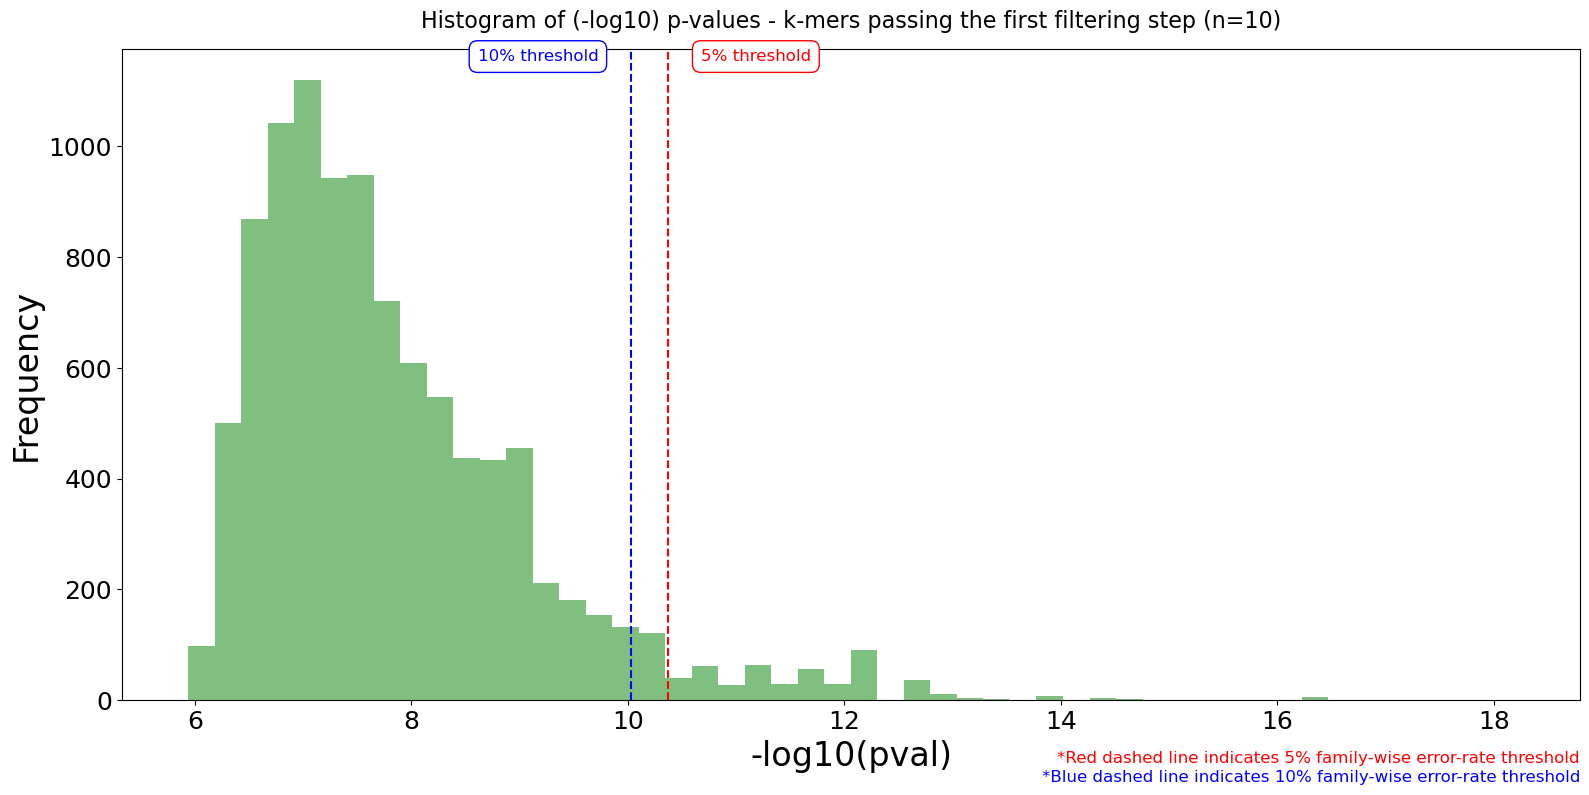

In [7]:
outdir = os.path.dirname("/mnt/home/carrele1/css844")
    
# Check if there are k-mers that pass the 5% threshold
if pass_threshold_5per.empty: # if no k-mers pass the 5% threshold
    with open(outdir + "/NO_KMERS_PASS_5PER_THRESHOLD_FOUND", 'a'): # create a file to indicate that no k-mers pass the 5% threshold
        print("No k-mers pass the 5% threshold.") # print a message to the user

# generate the table with the k-mers that pass the 5% threshold
print("Generating kmersGWAS summary table with k-mers that pass the 5% threshold...")
generate_kmers_gwas_results_table(pass_threshold = pass_threshold_5per, 
                                      threshold = threshold_5per, pheno=pheno, 
                                      output_file="5per_table.tsv")  
    
# Check if there are k-mers that pass the 10% threshold
if pass_threshold_10per.empty: # if no k-mers pass the 10% threshold
    with open(outdir + "/NO_KMERS_PASS_10PER_THRESHOLD_FOUND", 'a'): # create a file to indicate that no k-mers pass the 10% threshold
        print("No k-mers pass the 10% threshold.") # print a message to the user and exit the script

# generate the table with the k-mers that pass the 10% threshold
print("Generating kmersGWAS summary table with k-mers that pass the 10% threshold...")
generate_kmers_gwas_results_table(pass_threshold = pass_threshold_10per, 
                                      threshold = threshold_10per, 
                                      pheno = pheno, 
                                      output_file = "10per_table.tsv") 
    
# if k-mers pass the 5% threshold or the 10% threshold 
if not pass_threshold_5per.empty or not pass_threshold_10per.empty:
    
    # Plot the histogram of the -log10(p-value) values
    print("Plotting the histogram of the -log10(p-value) values...")
    plot_pval_histogram(pheno_val_assoc=pheno_val_assoc, 
                            threshold_5per=threshold_5per, 
                            threshold_10per=threshold_10per,
                            kmers_number=kmers_number, 
                            pheno=pheno,
                            out_dir = outdir)
    
    # if no k-mers pass the 5% threshold and no k-mers pass the 10% threshold
if pass_threshold_5per.empty and pass_threshold_10per.empty:
    # If output directory does not exist, create it
#         if not os.path.exists(snakemake.output.pval_hist_dir):
#             os.makedirs(snakemake.output.pval_hist_dir)
        
# Create a file to indicate that no k-mers pass the 5% threshold
    with open("/mnt/home/carrele1/css844" + "/NO_KMERS_PASS_10PER_THRESHOLD_FOUND", 'a'):
        print("No k-mers pass the 5% or the 10% threshold. No plots will be generated.") # print a message to the user and exit the script

# Q-Q Plots


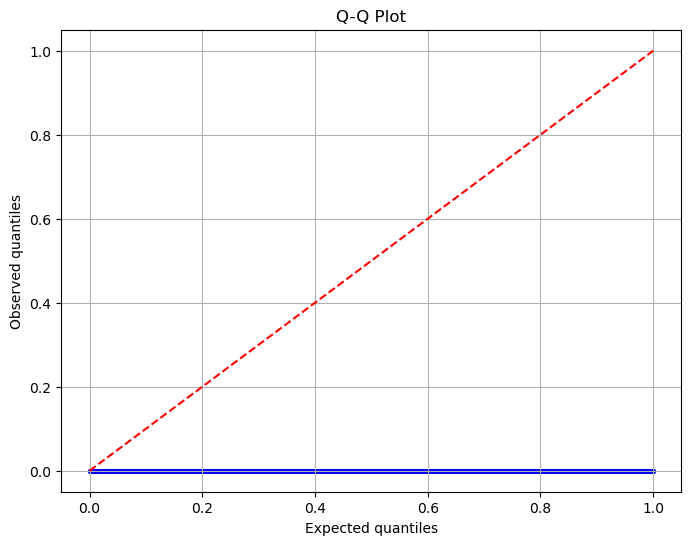

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Load test statistics from GEMMA output file (replace 'test_stats.txt' with your file)
# test_stats = np.loadtxt('/mnt/home/carrele1/css844/GWAS_dir/kmers/output/phenotype_value.assoc.txt')

df = pd.read_csv("/mnt/home/carrele1/css844/GWAS_dir/kmers/output/phenotype_value.assoc.txt", sep = '\t')
test_stats = df['p_lrt']

# Sort test statistics
sorted_stats = np.sort(test_stats)

# Compute expected quantiles
n = len(sorted_stats)
expected_quantiles = np.arange(1, n + 1) / (n + 1)

# Plot Q-Q plot
plt.figure(figsize=(8, 6))
plt.scatter(expected_quantiles, sorted_stats, color='blue', s=5)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('Expected quantiles')
plt.ylabel('Observed quantiles')
plt.title('Q-Q Plot')
plt.grid(True)
plt.show()


# Alignment
In order to generate a Manhattan plot, we need to align the significant k-mers to the reference genome. If we find unaligned sequences, we perform local assembly to identify indels. 

In [2]:
import csv
import os, glob, shutil
import pandas as pd
import numpy as np
import sys

In [10]:
# Input directory path for kmersGWAS results
res_dir_path = os.path.dirname("/mnt/home/carrele1/css844/GWAS_dir/")

# Set the threshold for k-mers GWAS results (%5 or %10 family-wise error rate)
threshold = 10

# Define the output directory
outdir = "/mnt/home/carrele1/css844/"
# print("Output directory: " + outdir)



In [13]:
# Define a function to fetch significant k-mers
def fetch_kmers(input_dir, pheno, out_dir, threshold):
    kmers_pass_threshold = pd.read_csv(input_dir + '/kmers/pass_threshold_{threshold}per'.
                                           format(threshold=threshold),
                               sep="\t") # read the k-mers that pass the threshold
        
    # Get significant k-mers without k-mer number
    kmers_pass_threshold['rs']= kmers_pass_threshold['rs'].apply(lambda x: x.split('_')[0])
    
    # print(kmers_pass_threshold) # For debugging only
    
    # Write significant k-mers list in TEXT format 
    print("Writing significant k-mers list in TEXT format...")
    kmers_pass_threshold['rs'].to_csv(out_dir + "/" + pheno + "_kmers_list.txt", 
                                             index=False, 
                                             sep="\t", 
                                             header=None) # write the k-mers list in a text file

    # Make a new column with k-mer number and its p_value (e.g. kmer1_8.543334e-11)
    kmers_pass_threshold['kmer_name']= 'kmer' + (kmers_pass_threshold.index+1).astype(str) + '_' + kmers_pass_threshold['p_lrt'].astype(str)
    
    # Write significant k-mers list in FASTA format (based on: https://www.biostars.org/p/271977/)
    # Fasta file output
    fileOutput = open(out_dir + "/" + pheno + "_kmers_list.fa", "w")
    
    # Seq count
    count = 1
    
    # Loop through each line in the input file
    print("Writing significant k-mers list in FASTA format...")
    for index, row in kmers_pass_threshold.iterrows():           
        #Output the header
        fileOutput.write(">" + row['kmer_name'] + "\n")
        fileOutput.write(row['rs'] + "\n")
        count = count + 1
  
    #Close the input and output file
    fileOutput.close()
    

In [14]:
# Fetch significant k-mers for the current phenotype
fetch_kmers(input_dir=res_dir_path, pheno="Period", out_dir=outdir , threshold=threshold)
        

Writing significant k-mers list in TEXT format...
Writing significant k-mers list in FASTA format...


# Manhattan Plot

In [1]:
# Do NOT run this command. It WILL crash the interactive session!
# pip install pysam

In [1]:
# import pandas and qmplot functions
import csv
import os, glob, shutil
import re
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from qmplot import manhattanplot
import natsort
from natsort import natsorted
import seaborn as sns
import pysam

ModuleNotFoundError: No module named 'pysam'

In [15]:
# Read the alignment data 
align_kmers_sam = pd.read_table("/mnt/scratch/carrele1/potato_output.sam", 
                sep='\t', comment='@', header=None,
                usecols=[0,2,3], names=['kmer_id', 'chr', 'bp'])
        

NameError: name 'snakemake' is not defined

# Merge Individual Tables
To generate a count-based k-mer table, we need to merge the individual count tables together. Since we have ~130 accessions, with count tables of size ~33GB, this needs to be done efficiently. 

In [1]:
import pandas as pd

In [ ]:
df = pd.read_csv("/mnt/scratch/carrele1/kmersGWAS_dir/AEM01/AEM01.txt")